## Import libraries

In [ ]:
# Install torchinfo, import if it's avaliable
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [ ]:
# See if required packages are installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
  print(f"torchmetrics version: {torchmetrics.__version__}")
  assert torchmetrics.__version__ >= "0.5.0", "torchmetrics version should be 0.5.0 or higher"
  print("mlxtend, torchmetrics installed and up-to-date")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
  print(f"torchmetrics version: {torchmetrics.__version__}")
  assert torchmetrics.__version__ >= "0.5.0", "torchmetrics version should be 0.5.0 or higher"
  print("mlxtend, torchmetrics installed and up-to-date")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 35.6 MB/s eta 0:00:00
mlxtend version: 0.23.1
torchmetrics version: 1.4.1
mlxtend, torchmetrics installed and up-to-date


In [ ]:
# Import essential libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

import os
import requests
import zipfile
from pathlib import Path

import pandas as pd

import random
from PIL import Image

from typing import Dict, List

from timeit import default_timer as timer

from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

## Setup data path and data source

In [ ]:
# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "WoodImages"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

Did not find data/WoodImages directory, creating one...


In [ ]:
# Unzip data, manually upload zip file to /data
zip_file_path = data_path / "WoodImages.zip"

if zip_file_path.is_file():
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        print("Unzipping images data...")
        zip_ref.extractall(image_path)
else:
    print(f"Error: Zip file not found at {zip_file_path}")


Unzipping images data...


In [ ]:
# data preparation and exploration
import os
def walk_through_dir(dir_path):
  """ Walk through dir_path returning its contents """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
# test image paths
walk_through_dir(image_path)

There are 1 directories and 0 images in 'data/WoodImages'.
There are 2 directories and 0 images in 'data/WoodImages/WoodImages'.
There are 9 directories and 0 images in 'data/WoodImages/WoodImages/Train'.
There are 29 directories and 0 images in 'data/WoodImages/WoodImages/Train/Tsuga_canadensis'.
There are 0 directories and 1 images in 'data/WoodImages/WoodImages/Train/Tsuga_canadensis/102.jpg'.
There are 0 directories and 1 images in 'data/WoodImages/WoodImages/Train/Tsuga_canadensis/119.jpg'.
There are 0 directories and 1 images in 'data/WoodImages/WoodImages/Train/Tsuga_canadensis/105.jpg'.
There are 0 directories and 1 images in 'data/WoodImages/WoodImages/Train/Tsuga_canadensis/126.jpg'.
There are 0 directories and 1 images in 'data/WoodImages/WoodImages/Train/Tsuga_canadensis/101.jpg'.
There are 0 directories and 1 images in 'data/WoodImages/WoodImages/Train/Tsuga_canadensis/117.jpg'.
There are 0 directories and 1 images in 'data/WoodImages/WoodImages/Train/Tsuga_canadensis/107.

In [ ]:
# Setup train and testing paths
train_dir = image_path / "WoodImages/Train"
test_dir = image_path / "WoodImages/Test"

train_dir, test_dir

(PosixPath('data/WoodImages/WoodImages/Train'),
 PosixPath('data/WoodImages/WoodImages/Test'))

## Loading image data (ImageFolder)

In [ ]:
# Create training transform with TriviailAugment

train_transform_trivial = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data

train_data_augmented = datasets.ImageFolder(
                                      root=train_dir,
                                      transform=train_transform_trivial)
test_data = datasets.ImageFolder(
                                      root=test_dir,
                                      transform=test_transform)


# 2. Turn the datasets into DataLoaders

# Setup batch size and number of workers
BATCH_SIZE = 12
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)

In [ ]:
# Get class names as list
class_names = train_data_augmented.classes
class_names

['Chamaecyparis_lawsoniana',
 'Chamaecyparis_nootkatensis',
 'Picea_abies',
 'Picea_glauca',
 'Pinus_elliottii',
 'Pseudotsuga_menziesii',
 'Sequoia_sempervirens',
 'Thuja_plicata',
 'Tsuga_canadensis']

In [ ]:
# Get class names as dict
class_dict = train_data_augmented.class_to_idx
class_dict

{'Chamaecyparis_lawsoniana': 0,
 'Chamaecyparis_nootkatensis': 1,
 'Picea_abies': 2,
 'Picea_glauca': 3,
 'Pinus_elliottii': 4,
 'Pseudotsuga_menziesii': 5,
 'Sequoia_sempervirens': 6,
 'Thuja_plicata': 7,
 'Tsuga_canadensis': 8}

In [ ]:
# Check the lengths of the dataset
len(train_data_augmented), len(test_data)

(309, 102)

In [ ]:
class TinyVGG(nn.Module):

  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units*2,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units*2,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)

    )

  def forward(self, x: torch.Tensor):
    return self.classifier(self.conv_block_2(self.conv_block_1(x))) #benefits from operator fusion


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=150,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(150, 150, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(150, 300, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(300, 150, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=25350, out_features=9, bias=True)
  )
)

In [ ]:
summary(model=model_1,
        input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 9]                    --
├─Sequential: 1-1                        [1, 150, 30, 30]          --
│    └─Conv2d: 2-1                       [1, 150, 62, 62]          4,200
│    └─ReLU: 2-2                         [1, 150, 62, 62]          --
│    └─Conv2d: 2-3                       [1, 150, 60, 60]          202,650
│    └─ReLU: 2-4                         [1, 150, 60, 60]          --
│    └─MaxPool2d: 2-5                    [1, 150, 30, 30]          --
├─Sequential: 1-2                        [1, 150, 13, 13]          --
│    └─Conv2d: 2-6                       [1, 300, 28, 28]          405,300
│    └─ReLU: 2-7                         [1, 300, 28, 28]          --
│    └─Conv2d: 2-8                       [1, 150, 26, 26]          405,150
│    └─ReLU: 2-9                         [1, 150, 26, 26]          --
│    └─MaxPool2d: 2-10                   [1, 150, 13, 13]          

In [ ]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in the train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss and accuracy values
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate loss and accuracy values
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
# 1. Create a train function that takes in various model parameters + optimizer + dataloaders+ loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  # 2. Create empty results dictionary
  results = {"train_loss": [],
          "train_acc": [],
          "test_loss": [],
          "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                             dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

## Training Process

In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 150

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.1788 | Train acc: 0.1314 | Test loss: 2.1450 | Test acc: 0.1759
Epoch: 1 | Train loss: 2.1480 | Train acc: 0.1741 | Test loss: 2.1267 | Test acc: 0.1852
Epoch: 2 | Train loss: 2.1335 | Train acc: 0.1677 | Test loss: 2.1449 | Test acc: 0.1667
Epoch: 3 | Train loss: 2.1309 | Train acc: 0.1816 | Test loss: 2.1316 | Test acc: 0.1852
Epoch: 4 | Train loss: 2.1174 | Train acc: 0.1506 | Test loss: 2.1222 | Test acc: 0.2037
Epoch: 5 | Train loss: 2.1217 | Train acc: 0.1741 | Test loss: 2.1153 | Test acc: 0.1852
Epoch: 6 | Train loss: 2.1151 | Train acc: 0.1656 | Test loss: 2.1250 | Test acc: 0.1759
Epoch: 7 | Train loss: 2.1191 | Train acc: 0.1720 | Test loss: 2.1314 | Test acc: 0.1667
Epoch: 8 | Train loss: 2.1162 | Train acc: 0.1645 | Test loss: 2.1205 | Test acc: 0.1944
Epoch: 9 | Train loss: 2.1154 | Train acc: 0.1880 | Test loss: 2.1247 | Test acc: 0.1759
Epoch: 10 | Train loss: 2.0993 | Train acc: 0.2201 | Test loss: 2.1159 | Test acc: 0.1852
Epoch: 11 | Train lo

In [ ]:
model_1_results

{'train_loss': [2.1787906976846547,
  2.147997966179481,
  2.1334785727354197,
  2.130942408855145,
  2.1174220075974097,
  2.121715022967412,
  2.115134972792405,
  2.1190672654371996,
  2.116187104812035,
  2.115419254853175,
  2.0992577442756066,
  2.09406302525447,
  2.101955982354971,
  2.078850498566261,
  2.009685727266165,
  1.9999016615060659,
  1.908135244479546,
  1.948919681402353,
  1.8686350308931792,
  1.8043996462455163,
  1.7407954702010522,
  1.6596244115095873,
  1.7056485460354731,
  1.6871388004376338,
  1.6918204380915716,
  1.569676506977815,
  1.5715909050061152,
  1.558241727260443,
  1.376193486727201,
  1.4887421795955071,
  1.4078481174432314,
  1.391936597915796,
  1.2803183495998383,
  1.208481809267631,
  1.3223469670002277,
  1.2142553627490997,
  1.1886132726302514,
  1.0010676716382687,
  1.1468005111584296,
  1.112444084424239,
  0.9859470472886012,
  0.9503408647500552,
  1.039888689151177,
  0.94664477958129,
  0.970737412571907,
  0.954196133292638

In [ ]:
# Get the model_0_results keys
model_1_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of a results dictionary.
  """
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))
  # Setup a plot
  plt.figure(figsize=(15, 7))
  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

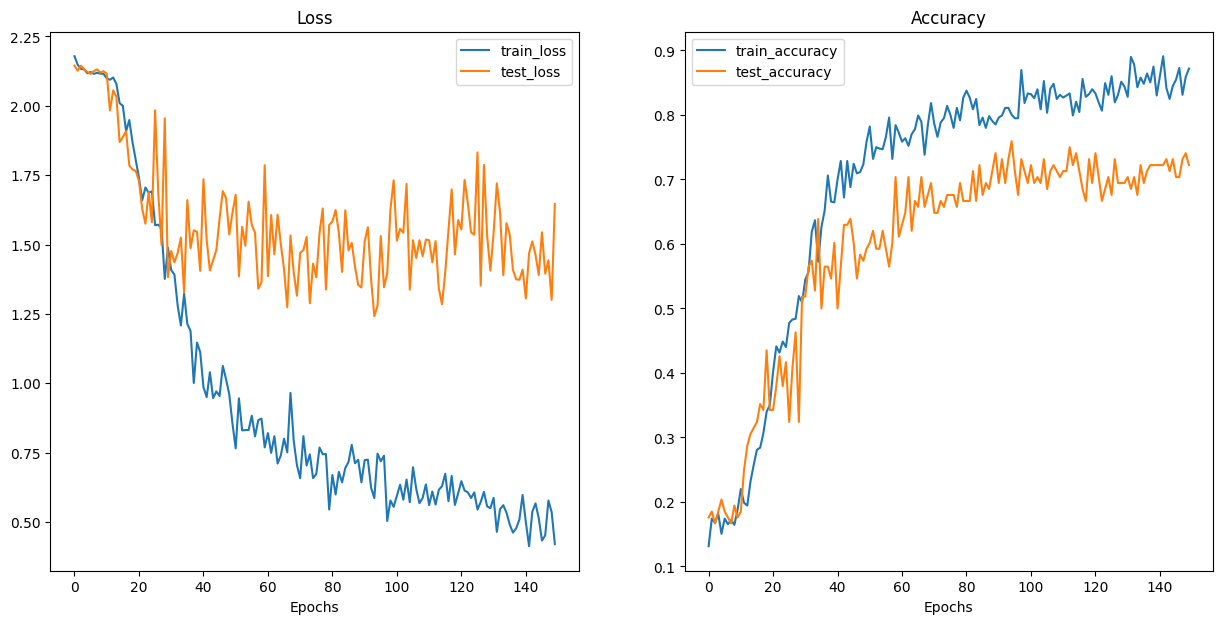

In [ ]:
plot_loss_curves(model_1_results)

## Prediction performance

In [ ]:
# random seed
#random.seed(42)
# 1. Get all image path
image_paths_list = list(image_path.glob("*/*/*/*/*.jpg"))

In [ ]:
len(image_paths_list)

411

In [ ]:
# make prediction
random_image_path_list =[]
random_image_class_list = []
random_image_list = []
# 2. Pick a random image list
for i in range(30):
  random_image_path_list.append(random.choice(image_paths_list))
  random_image_class_list.append(random_image_path_list[i].parents[1].stem)
  random_image = torchvision.io.read_image(str(random_image_path_list[i])).type(torch.float32) /255.
  # resize the image
  random_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
   ])
  # Transform target image
  random_image_transformed = random_image_transform(random_image)
  random_image_list.append(random_image_transformed)

In [ ]:
random_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
   ])

In [ ]:
def make_predictions(model: torch.nn.Module,
                        image_list: List[torch.Tensor],
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):

    pred_probs = []
    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      for sample in image_list:
        #sample = torchvision.io.read_image(str(sample)).type(torch.float32) /255.
        # Add an extra dimension to the image
        sample = sample.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        sample_pred_logit = model(sample.to(device))
        sample_pred_prob = torch.softmax(sample_pred_logit, dim=1)
        pred_probs.append(sample_pred_prob)
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [ ]:
# make preditions
pred_probs = make_predictions(model=model_1,
                              image_list=random_image_list,
                              class_names=class_names,
                              device=device)

In [ ]:
pred_probs[0]

tensor([[1.0616e-07, 2.4659e-05, 6.6118e-07, 5.3487e-09, 9.9311e-01, 6.7034e-03,
         2.9264e-06, 1.4016e-04, 1.8605e-05]], device='cuda:0')

In [ ]:
pred_probs[i].argmax(dim=1)

tensor([6], device='cuda:0')

In [ ]:
random_image_path_list[0].parents[0]

PosixPath('data/WoodImages/WoodImages/Train/Pinus_elliottii/13.jpg')

In [ ]:
# prediction sample list
pred_samples_list = []
for i in range(30):
  pred_sample_value = []
  pred_sample_value.append(random_image_path_list[i].parents[0])
  for j in range(len(class_names)):
    pred_sample_value.append(pred_probs[i][0][j].item())
  pred_samples_list.append(pred_sample_value)


In [ ]:
# show with panda table
import pandas as pd
df = pd.DataFrame(pred_samples_list, columns=['sample_image_path', '1', '2', '3', '4','5', '6', '7', '8', '9'])
df

,sample_image_path,1,2,3,4,5,6,7,8,9
0,data/WoodImages/WoodImages/Train/Pinus_elliott...,1.061613e-07,2.465942e-05,6.611781e-07,5.348662e-09,9.931095e-01,6.703425e-03,2.926402e-06,1.401622e-04,1.860498e-05
1,data/WoodImages/WoodImages/Train/Sequoia_sempe...,1.160844e-04,1.165229e-04,5.073433e-04,4.011655e-05,7.928042e-03,1.420904e-03,9.897462e-01,1.412645e-05,1.107030e-04
2,data/WoodImages/WoodImages/Test/Tsuga_canadens...,5.679845e-09,7.061177e-01,1.125097e-01,1.733739e-05,2.975942e-04,2.710472e-02,5.262837e-05,1.157713e-01,3.812898e-02
3,data/WoodImages/WoodImages/Train/Picea_glauca/...,2.172406e-06,2.432751e-05,7.683610e-06,9.998251e-01,3.755916e-06,3.210913e-07,1.249513e-04,1.538388e-06,1.014514e-05
4,data/WoodImages/WoodImages/Train/Chamaecyparis...,4.972263e-04,9.967913e-01,1.225531e-04,1.924593e-04,1.341118e-03,5.435765e-05,7.296061e-04,6.092020e-05,2.105891e-04
5,data/WoodImages/WoodImages/Train/Tsuga_canaden...,1.001037e-08,3.342710e-04,1.747954e-03,2.357800e-05,3.187064e-04,1.434755e-04,2.518275e-04,9.808333e-06,9.971704e-01
6,data/WoodImages/WoodImages/Test/Picea_glauca/1...,8.130523e-04,1.618510e-02,1.034299e-02,6.939691e-01,1.002685e-02,3.506562e-04,2.490597e-01,6.392603e-03,1.286003e-02
7,data/WoodImages/WoodImages/Test/Pseudotsuga_me...,7.459457e-04,6.268988e-04,7.041845e-03,2.992179e-05,4.063411e-02,9.316288e-01,5.322013e-03,1.359360e-02,3.769381e-04
8,data/WoodImages/WoodImages/Train/Pseudotsuga_m...,1.675558e-07,3.836480e-04,1.803466e-04,1.577626e-09,5.435285e-04,9.936203e-01,2.874619e-05,5.240784e-03,2.427891e-06
9,data/WoodImages/WoodImages/Train/Pseudotsuga_m...,1.180620e-07,7.135467e-06,2.009950e-10,1.158472e-10,1.358669e-06,9.996305e-01,5.275648e-08,3.608400e-04,2.962575e-10


In [ ]:
# Store each sample's probabilities value in dataframe


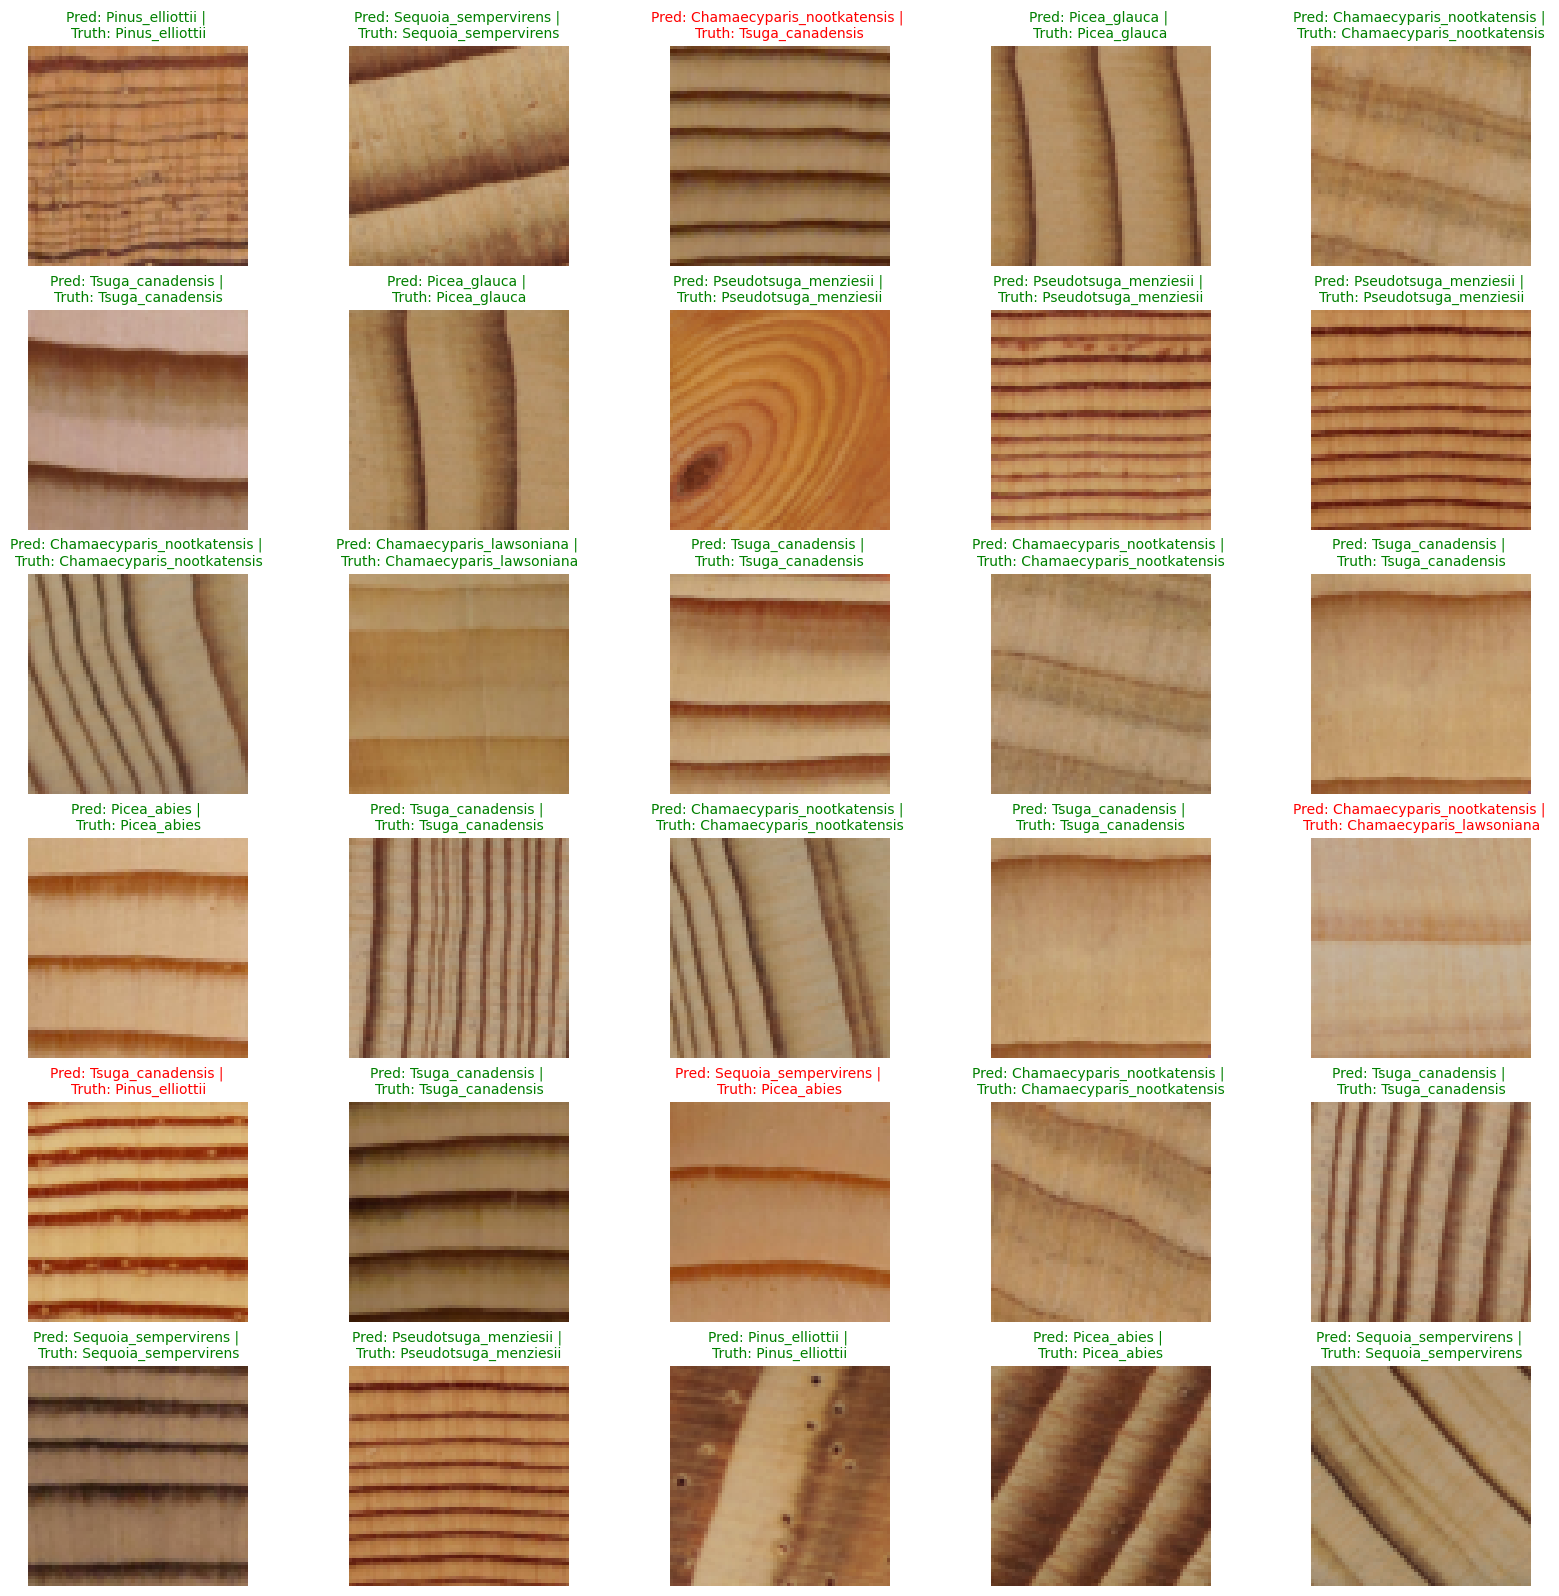

In [ ]:
# Plot predictions
plt.figure(figsize=(20, 20))
nrows = 6
ncols = 5
for i, sample in enumerate(random_image_list):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1, 2, 0))

  # Find the prediction (in text form)
  pred_label = class_names[pred_probs[i].argmax(dim=1)]

  # Get the truth label (in text form)
  truth_label = random_image_class_list[i]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | \nTruth: {truth_label}"

  # Check for equality
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r") # red text if prediction different than truth
  plt.axis(False);

In [ ]:
# 1. Make predictions with trained model
y_preds = []
y_probs = []
model_1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_1(X)

    # Store probabilities result
    y_probs.append(torch.softmax(y_logit.squeeze(), dim=1).cpu())
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=1).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
#print(y_preds)
y_pred_tensor = torch.cat(y_preds)
#y_pred_tensor[:10]

Making predictions:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
y_probs[0]

tensor([[2.7245e-08, 8.7495e-07, 9.7028e-01, 8.1259e-03, 1.6374e-02, 9.9619e-04,
         3.6234e-03, 8.0330e-05, 5.1699e-04],
        [2.2683e-03, 6.8320e-02, 4.7938e-03, 1.3433e-07, 2.7693e-03, 2.0895e-03,
         4.9423e-04, 1.8913e-03, 9.1737e-01],
        [3.6375e-08, 1.2432e-05, 1.9823e-04, 1.2922e-08, 1.6633e-01, 8.1388e-01,
         1.9212e-02, 5.4000e-05, 3.0865e-04],
        [8.8142e-06, 1.2463e-07, 8.7528e-04, 1.6140e-06, 2.2461e-03, 9.0360e-04,
         9.9588e-01, 9.4834e-06, 7.1363e-05],
        [1.7281e-03, 1.0723e-01, 1.2901e-03, 8.3180e-04, 1.4415e-02, 1.2808e-02,
         8.5907e-01, 3.5493e-04, 2.2649e-03],
        [7.4493e-04, 6.3619e-04, 7.0910e-03, 3.0583e-05, 4.1038e-02, 9.3107e-01,
         5.3803e-03, 1.3625e-02, 3.8778e-04],
        [5.2820e-04, 8.6386e-03, 1.1330e-03, 4.4434e-03, 6.5552e-03, 3.8597e-03,
         9.7107e-01, 1.3360e-04, 3.6405e-03],
        [1.3894e-02, 4.0579e-01, 2.5951e-02, 9.1346e-03, 2.3903e-01, 1.1732e-01,
         4.1895e-02, 1.2878e-0

In [ ]:
# from list to tensor
torch.Tensor(test_data.targets)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 7., 7., 7., 7.,
        8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.])

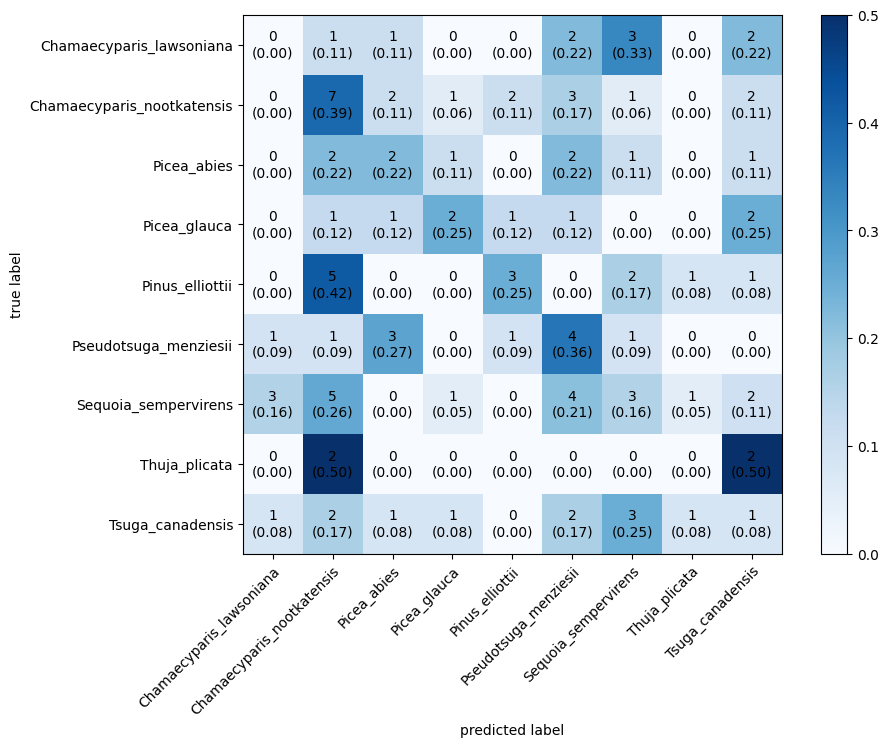

In [ ]:
# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass',
                          num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_data.targets))


# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with numpy
    class_names=class_names,
    show_normed=True,
    colorbar=True,
    figsize=(10, 7))


## Save model

In [ ]:
# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save
MODEL_NAME = "ML_wood_classification_wider_b12_lr0001_dropout.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/ML_wood_classification_wider_b12_lr0001_dropout.pth


In [ ]:
# Create a new instance
torch.manual_seed(42)
loaded_model_2 = TinyVGG(input_shape=3,
                  hidden_units=150,
                  output_shape=len(train_data_augmented.classes)).to(device)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2.to(device)

RuntimeError: Error(s) in loading state_dict for TinyVGG:
	size mismatch for conv_block_1.0.weight: copying a param with shape torch.Size([50, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([150, 3, 3, 3]).
	size mismatch for conv_block_1.0.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([150]).
	size mismatch for conv_block_1.2.weight: copying a param with shape torch.Size([50, 50, 3, 3]) from checkpoint, the shape in current model is torch.Size([150, 150, 3, 3]).
	size mismatch for conv_block_1.2.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([150]).
	size mismatch for conv_block_2.0.weight: copying a param with shape torch.Size([100, 50, 3, 3]) from checkpoint, the shape in current model is torch.Size([300, 150, 3, 3]).
	size mismatch for conv_block_2.0.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([300]).
	size mismatch for conv_block_2.2.weight: copying a param with shape torch.Size([50, 100, 3, 3]) from checkpoint, the shape in current model is torch.Size([150, 300, 3, 3]).
	size mismatch for conv_block_2.2.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([150]).
	size mismatch for classifier.1.weight: copying a param with shape torch.Size([9, 8450]) from checkpoint, the shape in current model is torch.Size([9, 25350]).